In [1]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click to toggle code"></form>''')

In [2]:
!rm -Rf ~/.cache/rootpy pax_*
import os, sys
import numpy as np
from multihist import Histdd, Hist1d
import matplotlib
from matplotlib.colors import LogNorm
import matplotlib.pyplot as plt
%matplotlib inline 
import pandas as pd
from scipy.optimize import curve_fit, minimize
pd.options.mode.chained_assignment = None        # default='warn'
import warnings
warnings.filterwarnings('ignore')

# -------------------- Make empyty dataframes w/ right cols to fill with data

rn_samp = pd.read_pickle('/home/shawaf/calibration_data/with_new_features/pax_v6.6.5_v1/pax_v6.6.5_rn_event_combine_v1/170313_2018.pkl')
ambe_samp = pd.read_pickle('/home/shawaf/calibration_data/with_new_features/pax_v6.6.5_v1/pax_v6.6.5_ambe_event_combine_v1/170316_0834.pkl')

rn = pd.DataFrame(columns = list(rn_samp))
ambe = pd.DataFrame(columns = list(ambe_samp))

# ------------------- Import it ALL into one dataframe

for filename in os.listdir('/home/shawaf/calibration_data/with_new_features/pax_v6.6.5_v1/pax_v6.6.5_rn_event_combine_v1/'):
    df = pd.read_pickle('/home/shawaf/calibration_data/with_new_features/pax_v6.6.5_v1/pax_v6.6.5_rn_event_combine_v1/' + str(filename))
    rn = rn.append(df)

for filename in os.listdir('/home/shawaf/calibration_data/with_new_features/pax_v6.6.5_v1/pax_v6.6.5_ambe_event_combine_v1/'):
    df = pd.read_pickle('/home/shawaf/calibration_data/with_new_features/pax_v6.6.5_v1/pax_v6.6.5_ambe_event_combine_v1/' + str(filename))
    ambe = ambe.append(df)
    
ambe = ambe[ambe.s2>200]

## define functions for quicker graphing

In [3]:
def slicing(df, x_feat, y_feat, bins):
    """Designed to slice in a 2-d space, fit gauss to those slices, and return a binned dataframe"""
    bin_mids = []
    
    sigmas = []
    means = []

    for i in range(1, len(bins)):
        a = df.loc[(df[x_feat] < bins[i]) & (df[x_feat] > bins[i-1])]

        mn = np.mean(a[y_feat])
        sg = np.std(a[y_feat])
        bm = np.mean(a[x_feat])

        if (np.logical_not(np.isnan(mn)) & np.logical_not(np.isnan(sg))):
            means.append(mn)
            sigmas.append(sg)
            bin_mids.append(bm)

    return pd.DataFrame(np.array([bin_mids, means, sigmas]).T, index = range(len(means)), columns = [x_feat,y_feat,'sigma'])

In [4]:
def plot2d_compare(x, y,xlim=None, ylim=None):
    plt.figure(figsize=(8,6))
    plt.scatter(cut_ambe[x], cut_ambe[y], color='r', label='ambe', s=0.2)
    
    plt.scatter(sim[x], sim[y], color='b', label='sim', s=0.2)
    
    plt.xlim(xlim)
    plt.ylim(ylim)
    
    plt.xlabel(x)
    plt.ylabel(y)
    
    plt.legend(loc='upper left')

In [5]:
def line_cut(df, values, less_greater, value):
    if less_greater in ("less","<","less than"):
        return df[df[values] < value]
    elif less_greater in ("greater",">","greater than"):
        return df[df[values] > value]

In [6]:
# ------------------- The linear cut used in s2 - other largest s2 space for SS

def ses2_size_cut_ori(s2_area):
    linear_0 = s2_area * 0.00832 + 72.3
    linear_1 = s2_area * 0.03 - 109
    fermi_dirac_coef_0 = 1 / (np.exp((s2_area - 23300) * 5.91e-4) + 1)
    fermi_dirac_coef_1 = 1 / (np.exp((23300 - s2_area) * 5.91e-4) + 1)
    return linear_0*fermi_dirac_coef_0+linear_1*fermi_dirac_coef_1

In [7]:
def four_hist_compare(df_1, df_2, slice_in_x, y, plot_ranges):
    """Will take in two dataframes and plot their histograms in y atop eachother in the 4 ranges of slice_in_x
    specified by plot_ranges"""
    fig = plt.figure(figsize=(10,7))
    # ----------------------------------------
    ax = fig.add_subplot(221)

    slice_df_1 = df_1[(df_1[slice_in_x] > plot_ranges[0][0]) & (df_1[slice_in_x] < plot_ranges[0][1])]
    slice_df_2 = df_2[(df_2[slice_in_x] > plot_ranges[0][0]) & (df_2[slice_in_x] < plot_ranges[0][1])]

    ax.hist(slice_df_1[y].dropna(), bins=50, color='b', alpha=1, label='sim', normed=1)
    ax.hist(slice_df_2[y].dropna(), bins=50, color='r', alpha=0.5, label='ambe', normed=1)

    ax.set_title( "%s to %s, %s" % (plot_ranges[0][0], plot_ranges[0][1], slice_in_x))

    # ----------------------------------------
    ax = fig.add_subplot(222)

    slice_df_1 = df_1[(df_1[slice_in_x] > plot_ranges[1][0]) & (df_1[slice_in_x] < plot_ranges[1][1])]
    slice_df_2 = df_2[(df_2[slice_in_x] > plot_ranges[1][0]) & (df_2[slice_in_x] < plot_ranges[1][1])]

    ax.hist(slice_df_1[y].dropna(), bins=40, color='b', alpha=1, label='sim', normed=1)
    ax.hist(slice_df_2[y].dropna(), bins=40, color='r', alpha=0.5,  label='ambe', normed=1)

    ax.set_title( "%s to %s, %s" % (plot_ranges[1][0], plot_ranges[1][1], slice_in_x))

    ax.legend(loc = 'upper right')

    # ----------------------------------------
    ax = fig.add_subplot(223)

    slice_df_1 = df_1[(df_1[slice_in_x] > plot_ranges[2][0]) & (df_1[slice_in_x] < plot_ranges[2][1])]
    slice_df_2 = df_2[(df_2[slice_in_x] > plot_ranges[2][0]) & (df_2[slice_in_x] < plot_ranges[2][1])]

    ax.hist(slice_df_1[y].dropna(), bins=25, color='b', alpha=1, label='sim', normed=1)
    ax.hist(slice_df_2[y].dropna(), bins=25, color='r', alpha=0.5,  label='ambe', normed=1)

    ax.set_title( "%s to %s, %s" % (plot_ranges[2][0], plot_ranges[2][1], slice_in_x))

    # ----------------------------------------
    ax = fig.add_subplot(224)

    slice_df_1 = df_1[(df_1[slice_in_x] > plot_ranges[3][0]) & (df_1[slice_in_x] < plot_ranges[3][1])]
    slice_df_2 = df_2[(df_2[slice_in_x] > plot_ranges[3][0]) & (df_2[slice_in_x] < plot_ranges[3][1])]

    ax.hist(slice_df_1[y].dropna(), bins=35, color='b', alpha=1, label='sim', normed=1)
    ax.hist(slice_df_2[y].dropna(), bins=35, color='r', alpha=0.5, label='ambe', normed=1)

    ax.set_title( "%s to %s, %s" % (plot_ranges[3][0], plot_ranges[3][1], slice_in_x))

In [8]:
cut_ambe = ambe[ambe.s2_1_area < ses2_size_cut_ori(ambe.s2)]

In [9]:
# building the csv instruct file from AmBe data
want = ['x','y','z','cs1','cs2']
a = cut_ambe[want]
a['z'] = -1 * a['z']
a['cs1'] = a['cs1'] / .12
a = a.dropna()

# simulator takes s2 electrons to determine s2
pe_per_e = 25
a['cs2'] = a['cs2'] / pe_per_e

# a.to_csv('~/data/nr_ss_sim/nrsim_from_ambe_help.csv')

#Then simulate w fax

In [10]:
# Load in sim data
import hax

# using modified version of Tianyu's OtherLargeS2s peak extractor
from make_minitree import Peaks

hax.init(experiment='XENON1T',
         use_runs_db=False,
         pax_version_policy='loose',
         main_data_paths=['~/data/nr_ss_sim/nrsim_from_ambe_v_4'],
         minitree_paths = ['~/data/nr_ss_sim/nrsim_from_ambe_v_4'])

INFO:hax.__init__] Not looking for datasets in runs, db since you put use_runs_db = False


In [11]:
sim = hax.minitrees.load("nrsim_from_ambe_drift_corrected",[Peaks])

DEBUG:hax.minitrees] Found minitree at /home/shawaf/data/nr_ss_sim/nrsim_from_ambe_v_4/nrsim_from_ambe_drift_corrected_Peaks.root
DEBUG:hax.minitrees] Found minitree at /home/shawaf/data/nr_ss_sim/nrsim_from_ambe_v_4/nrsim_from_ambe_drift_corrected_Peaks.root
DEBUG:hax.minitrees] Removing weird index column


In [12]:
# dropping poor events
sim = sim.dropna(subset = ['x','y','s2'])

In [13]:
# need some more quantities of the data
sim['r'] = np.sqrt(sim.x**2 + sim.y**2)
cut_ambe['r'] = np.sqrt(cut_ambe.x**2 + cut_ambe.y**2)

sim['s2_1_r'] = np.sqrt(sim.s2_1_x**2 + sim.s2_1_y**2)
cut_ambe['s2_1_r'] = np.sqrt(cut_ambe.s2_1_x**2 + cut_ambe.s2_1_y**2)

Have all the data ready, now to go through the spaces and compare simulation to real data

# Area, width ---- s2 and largest other  s2

## Main s2

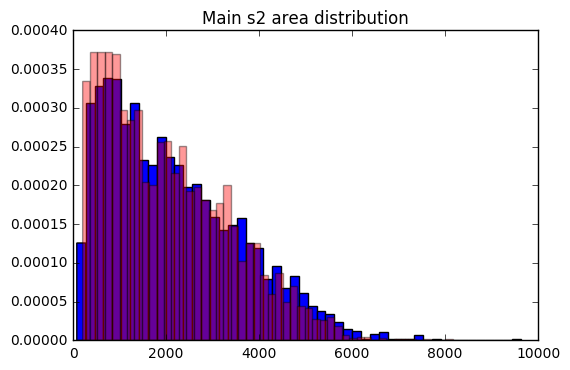

In [14]:
plt.hist(sim.s2,bins=50, color='b',label='sim', normed=1)
plt.hist(cut_ambe.s2, bins=50,alpha=.4,color='r',label='ambe', normed=1)
plt.title('Main s2 area distribution')
plt.show()

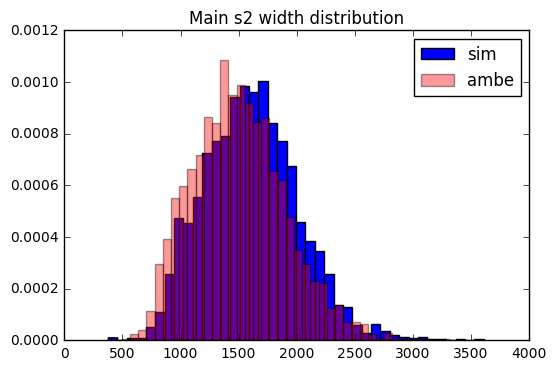

ambe mean: 1502.0739921
ambe std: 401.807996107
sim mean: 1606.54820789
sim std: 407.960713083


In [47]:
plt.hist(sim.s2_range_50p_area,bins=40, color='b',label='sim', normed=1)
plt.hist(cut_ambe.s2_range_50p_area, bins=40,alpha=.4,color='r',label='ambe', normed=1)
plt.legend(loc='upper right')
plt.title('Main s2 width distribution')
plt.show()

print('ambe mean:' , np.mean(cut_ambe.s2_range_50p_area.dropna()))
print('ambe std:' , np.std(cut_ambe.s2_range_50p_area.dropna()))
print('sim mean:' , np.mean(sim.s2_range_50p_area.dropna()))
print('sim std:' , np.std(sim.s2_range_50p_area.dropna()))

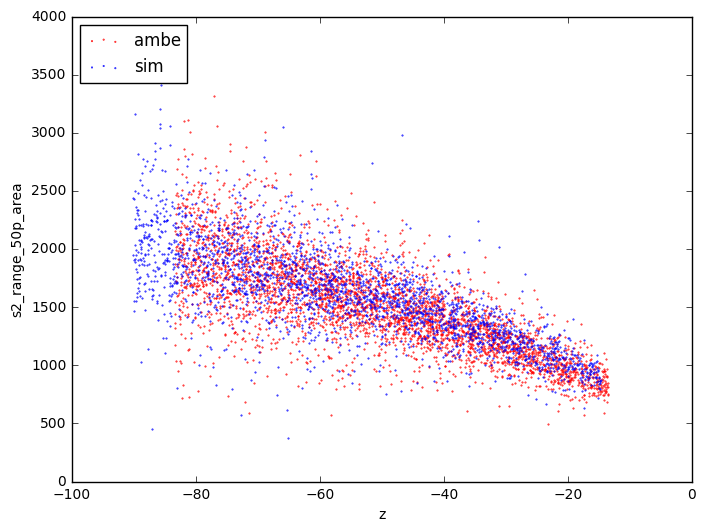

In [16]:
plot2d_compare('z','s2_range_50p_area')

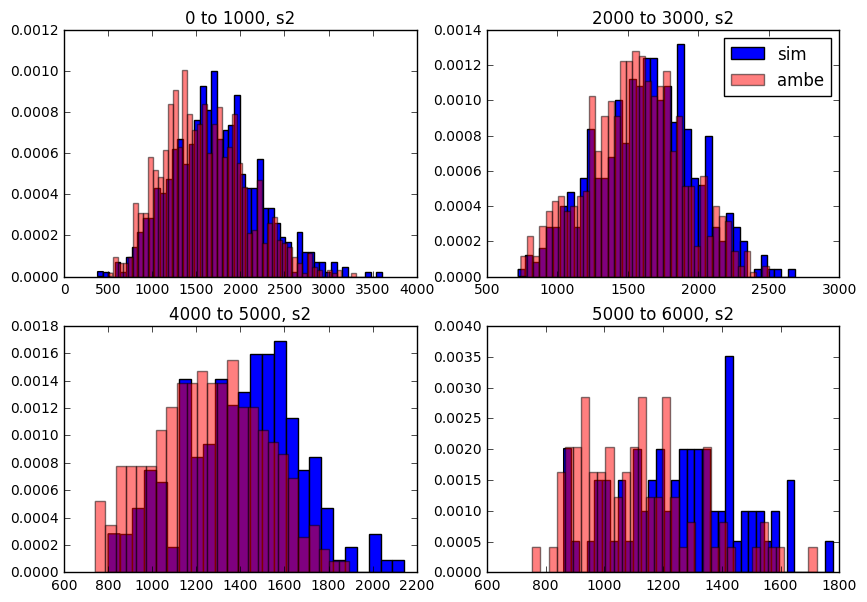

In [17]:
plt_ranges = [[0,1000],[2000,3000],[4000,5000],[5000,6000]]
four_hist_compare(sim, cut_ambe, 's2', 's2_range_50p_area', plt_ranges)

In [18]:
ambe_bins = np.linspace(0,8000,30)
sim_bins = np.linspace(0,8000,28)
ambe_area_width = slicing(cut_ambe, 's2', 's2_range_50p_area', ambe_bins)
sim_area_width = slicing(sim, 's2', 's2_range_50p_area', sim_bins)

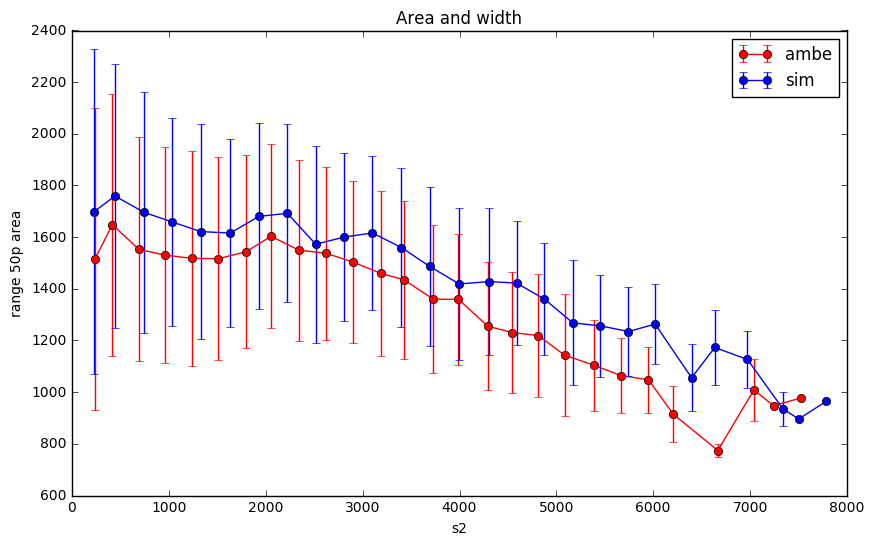

In [19]:
plt.figure(figsize = (10,6))
plt.errorbar(ambe_area_width.s2, ambe_area_width.s2_range_50p_area, ambe_area_width.sigma, color = 'r', marker='o', label='ambe')
plt.errorbar(sim_area_width.s2, sim_area_width.s2_range_50p_area, sim_area_width.sigma, color = 'b',marker='o', label = 'sim')
plt.title('Area and width')
plt.xlabel('s2')
plt.ylabel('range 50p area')
plt.legend(loc='upper right')
plt.show()

## Largest other s2

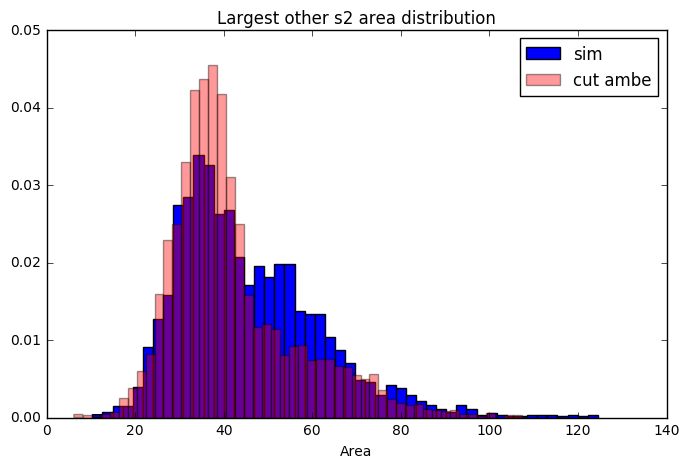

In [20]:
plt.figure(figsize=(8,5))
plt.hist(sim[sim.s2_1_area < 150].s2_1_area.dropna(),bins=50, color='b',label='sim', normed=1)
plt.hist(cut_ambe.s2_1_area.dropna(), bins=50,alpha=.4,color='r',label='cut ambe', normed=1)
plt.title('Largest other s2 area distribution')
plt.xlabel('Area')
plt.legend()
plt.show()

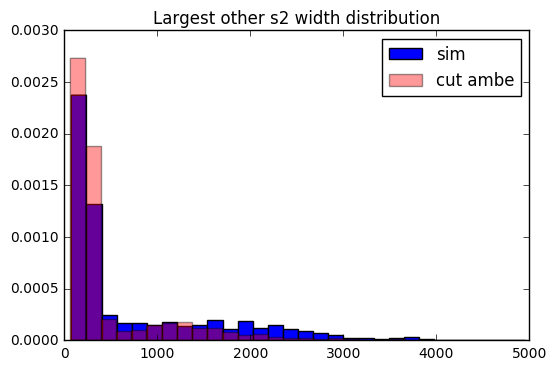

In [21]:
plt.hist(sim[sim.s2_1_range_50p_area < 5000].s2_1_range_50p_area.dropna(),bins=30, color='b',label='sim', normed=1)
plt.hist(cut_ambe[cut_ambe.s2_1_range_50p_area < 5000].s2_1_range_50p_area.dropna(), bins=30,alpha=.4,color='r',label='cut ambe', normed=1)
plt.title('Largest other s2 width distribution')
plt.legend()
plt.show()

# r, z, time delays

## Main s2

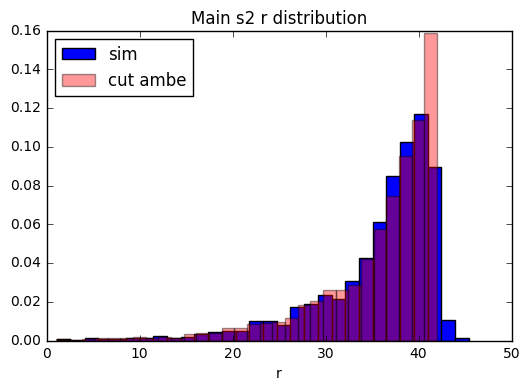

In [22]:
plt.hist(sim.r.dropna(), bins=30, color='b',label='sim', normed=1)
plt.hist(cut_ambe.r.dropna(), bins=30,alpha=.4,color='r',label='cut ambe', normed=1)
plt.title('Main s2 r distribution')
plt.legend(loc = 'upper left')
plt.xlabel('r')
plt.show()

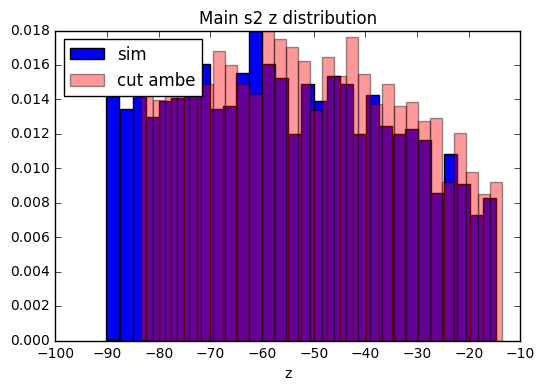

In [23]:
plt.hist(sim.z.dropna(), bins=30, color='b',label='sim', normed=1)
plt.hist(cut_ambe.z.dropna(), bins=30,alpha=.4,color='r',label='cut ambe', normed=1)
plt.title('Main s2 z distribution')
plt.legend(loc = 'upper left')
plt.xlabel('z')
plt.show()

I simulated directly from the cut_ambe z distribution, so why would the simulation extend to -90??

## Largest other s2

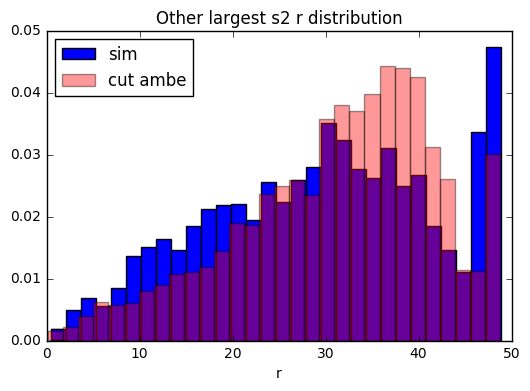

In [24]:
plt.hist(sim.s2_1_r.dropna(), bins=30, color='b',label='sim', normed=1)
plt.hist(cut_ambe.s2_1_r.dropna(), bins=30,alpha=.4,color='r',label='cut ambe', normed=1)
plt.title('Other largest s2 r distribution')
plt.legend(loc = 'upper left')
plt.xlabel('r')
plt.show()

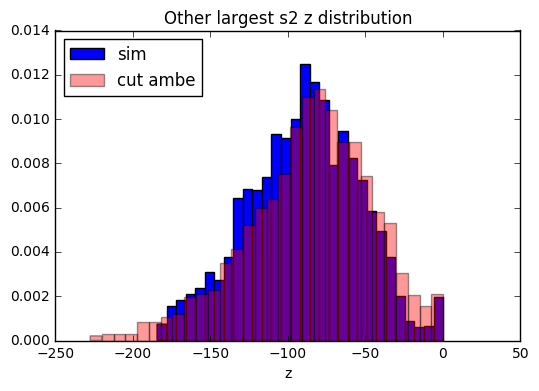

In [25]:
plt.hist(sim.s2_1_z.dropna(), bins=30, color='b',label='sim', normed=1)
plt.hist(cut_ambe.s2_1_z.dropna(), bins=30,alpha=.4,color='r',label='cut ambe', normed=1)
plt.title('Other largest s2 z distribution')
plt.legend(loc = 'upper left')
plt.xlabel('z')
plt.show()

## Time delays

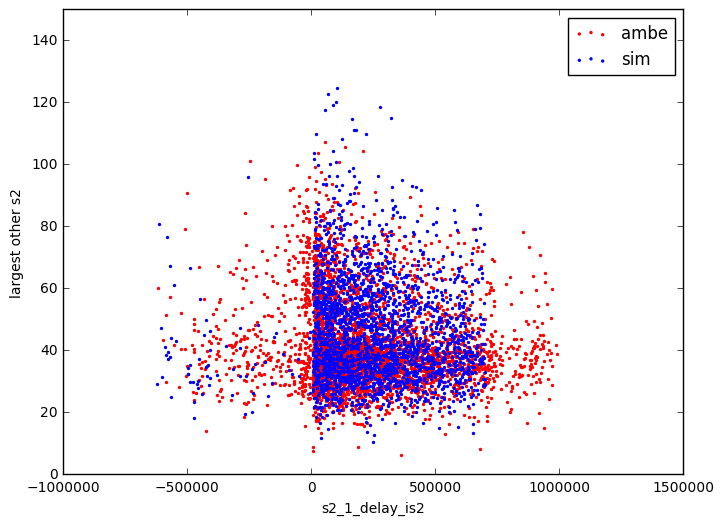

In [26]:
plt.figure(figsize = (8,6))
plt.scatter(cut_ambe.s2_1_delay_is2, cut_ambe.s2_1_area,label='ambe', color='r',s = 2)
plt.scatter(sim.s2_1_delay_is2, sim.s2_1_area, label='sim', color = 'b', s = 2)

plt.ylim(0,150)

plt.title('')
plt.xlabel('s2_1_delay_is2')
plt.ylabel('largest other s2')

plt.legend(loc = 'upper right')
plt.show()

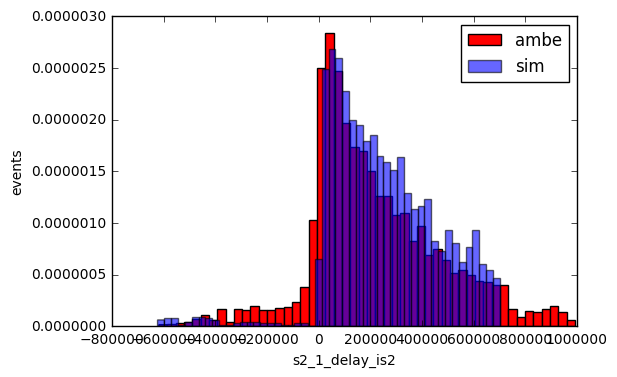

In [27]:
plt.hist(cut_ambe.s2_1_delay_is2.dropna(), bins=50, normed = 1, color='r', label = 'ambe')
plt.hist(sim.s2_1_delay_is2.dropna(), bins=50, normed = 1, color='b', label='sim', alpha = 0.6)

plt.xlabel('s2_1_delay_is2')
plt.ylabel('events')

plt.legend(loc='upper right')

plt.show()

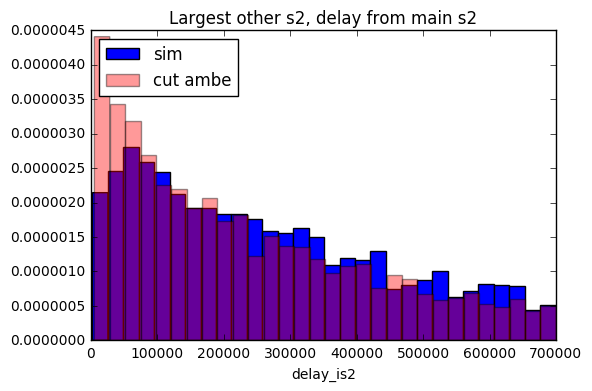

In [28]:
plt.hist(sim[(sim.s2_1_delay_is2 > -1000) & (sim.s2_1_delay_is2 < 700000)].s2_1_delay_is2.dropna(), bins=30, color='b',label='sim', normed=1)
plt.hist(cut_ambe[(cut_ambe.s2_1_delay_is2 > -1000) & (cut_ambe.s2_1_delay_is2 < 700000)].s2_1_delay_is2.dropna(), bins=30,alpha=.4,color='r',label='cut ambe', normed=1)
plt.title('Largest other s2, delay from main s2')
plt.legend(loc = 'upper left')
plt.xlabel('delay_is2')
plt.show()

In [29]:
bins = np.linspace(0,700000,30)
ambe_delay_area = slicing(cut_ambe, 's2_1_delay_is2', 's2_1_area', bins)
sim_delay_area = slicing(sim, 's2_1_delay_is2', 's2_1_area', bins)

### Looking between 0 and 700,000 delay from main s2

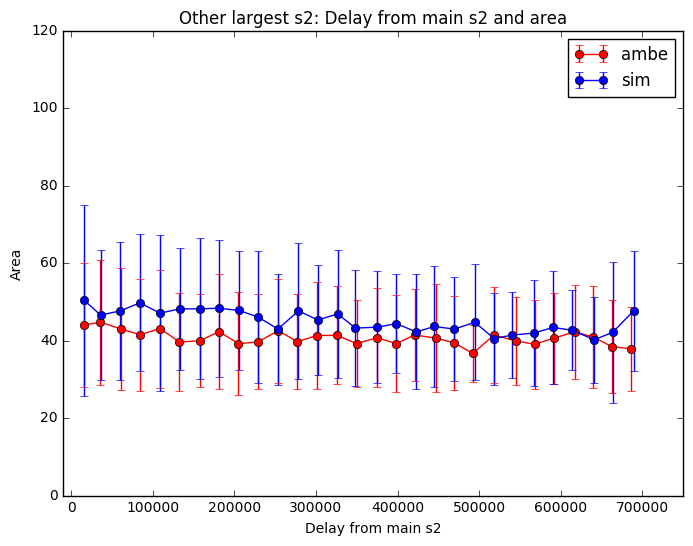

In [30]:
plt.figure(figsize=(8,6))
plt.errorbar(ambe_delay_area.s2_1_delay_is2, ambe_delay_area.s2_1_area, ambe_delay_area.sigma, label='ambe', color='r', marker = 'o')
plt.errorbar(sim_delay_area.s2_1_delay_is2, sim_delay_area.s2_1_area, sim_delay_area.sigma, label='sim', color='b', marker = 'o')

plt.xlabel('Delay from main s2')
plt.ylabel('Area')

plt.xlim(-10000, 750000)
plt.ylim(0,120)

plt.title('Other largest s2: Delay from main s2 and area')

plt.legend(loc='upperright')
plt.show()

### Fixing the other largest s2 area distribution will make this match better?

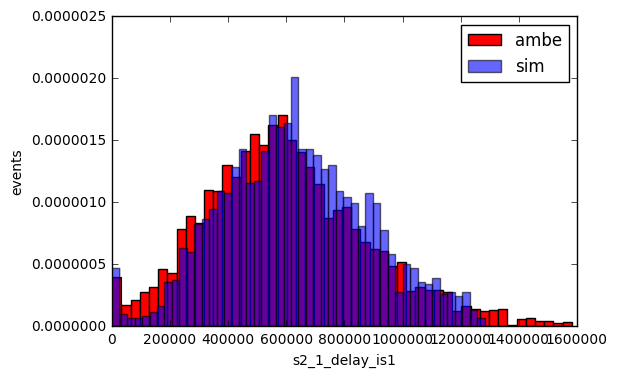

In [31]:
plt.hist(cut_ambe.s2_1_delay_is1.dropna(), bins=50, normed = 1, color='r', label = 'ambe')
plt.hist(sim.s2_1_delay_is1.dropna(), bins=50, normed = 1, color='b', label='sim', alpha = 0.6)

plt.xlabel('s2_1_delay_is1')
plt.ylabel('events')

plt.legend(loc='upper right')

plt.show()

In [32]:
print('ambe mean:' , np.mean(cut_ambe.s2_1_delay_is1.dropna()))
print('ambe std:' , np.std(cut_ambe.s2_1_delay_is1.dropna()))
print('sim mean:' , np.mean(sim.s2_1_delay_is1.dropna()))
print('sim std:' , np.std(sim.s2_1_delay_is1.dropna()))

ambe mean: 599263.830243
ambe std: 281801.821144
sim mean: 628754.339326
sim std: 252001.555559


# S2 - Largest other S2

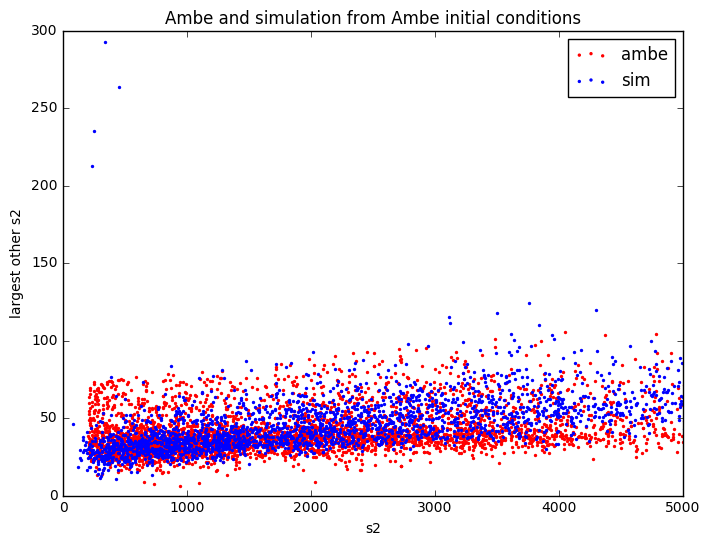

In [33]:
plt.figure(figsize = (8,6))
plt.scatter(cut_ambe.s2, cut_ambe.s2_1_area,label='ambe', color='r',s = 2)
plt.scatter(sim.s2, sim.s2_1_area, label='sim', color = 'b', s = 2)
plt.xlim(0,5000)
plt.ylim(0,300)
plt.title('Ambe and simulation from Ambe initial conditions')
plt.xlabel('s2')
plt.ylabel('largest other s2')

plt.legend(loc = 'upper right')
plt.show()

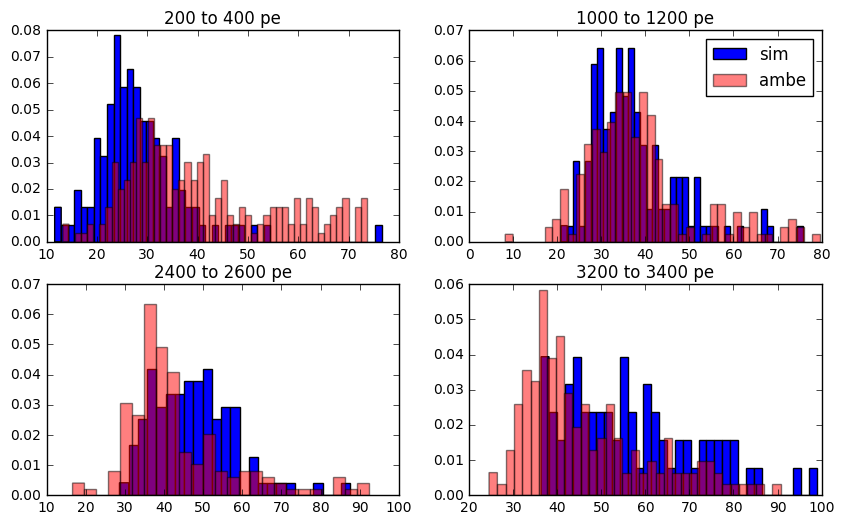

In [34]:
fig = plt.figure(figsize=(10,6))

plot_ranges = [[200,400],[1000,1200],[2400,2600],[3200,3400]]


df_1 = sim
df_2 = cut_ambe

# ----------------------------------------
ax = fig.add_subplot(221)

slice_df_1 = df_1[(df_1.s2 > plot_ranges[0][0]) & (df_1.s2 < plot_ranges[0][1])]
slice_df_2 = df_2[(df_2.s2 > plot_ranges[0][0]) & (df_2.s2 < plot_ranges[0][1])]

slice_df_1 = line_cut(slice_df_1, 's2_1_area', '<', 100)

ax.hist(slice_df_1.s2_1_area.dropna(), bins=50, color='b', alpha=1, label='sim', normed=1)
ax.hist(slice_df_2.s2_1_area.dropna(), bins=50, color='r', alpha=0.5, label='ambe', normed=1)

ax.set_title( "%s to %s pe" % (plot_ranges[0][0], plot_ranges[0][1]))

# ----------------------------------------
ax = fig.add_subplot(222)

slice_df_1 = df_1[(df_1.s2 > plot_ranges[1][0]) & (df_1.s2 < plot_ranges[1][1])]
slice_df_2 = df_2[(df_2.s2 > plot_ranges[1][0]) & (df_2.s2 < plot_ranges[1][1])]

ax.hist(slice_df_1.s2_1_area.dropna(), bins=40, color='b', alpha=1, label='sim', normed=1)
ax.hist(slice_df_2.s2_1_area.dropna(), bins=40, color='r', alpha=0.5,  label='ambe', normed=1)

ax.set_title( "%s to %s pe" % (plot_ranges[1][0], plot_ranges[1][1]))

ax.legend(loc = 'upper right')

# ----------------------------------------
ax = fig.add_subplot(223)

slice_df_1 = df_1[(df_1.s2 > plot_ranges[2][0]) & (df_1.s2 < plot_ranges[2][1])]
slice_df_2 = df_2[(df_2.s2 > plot_ranges[2][0]) & (df_2.s2 < plot_ranges[2][1])]

ax.hist(slice_df_1.s2_1_area.dropna(), bins=25, color='b', alpha=1, label='sim', normed=1)
ax.hist(slice_df_2.s2_1_area.dropna(), bins=25, color='r', alpha=0.5,  label='ambe', normed=1)

ax.set_title( "%s to %s pe" % (plot_ranges[2][0], plot_ranges[2][1]))

# ----------------------------------------
ax = fig.add_subplot(224)

slice_df_1 = df_1[(df_1.s2 > plot_ranges[3][0]) & (df_1.s2 < plot_ranges[3][1])]
slice_df_2 = df_2[(df_2.s2 > plot_ranges[3][0]) & (df_2.s2 < plot_ranges[3][1])]

ax.hist(slice_df_1.s2_1_area.dropna(), bins=35, color='b', alpha=1, label='sim', normed=1)
ax.hist(slice_df_2.s2_1_area.dropna(), bins=35, color='r', alpha=0.5, label='ambe', normed=1)

ax.set_title( "%s to %s pe" % (plot_ranges[3][0], plot_ranges[3][1]))
    
plt.show()

In [35]:
# What's that, the outliers in sim with large other s2
whats_that_s2_1 = sim[sim.s2_1_area >200]
whats_that_s2_1

,cs1,cs2,event_number,goodness_of_fit,run_number,s1,s2,s2_1_area,s2_1_delay_is1,s2_1_delay_is2,...,s2_5_x,s2_5_y,s2_5_z,s2_delay_is1,s2_range_50p_area,x,y,z,r,s2_1_r
971,13.036266,908.858509,971,146.121170,0,14.177604,334.768097,292.341187,464697.75000,-1925.0000,...,24.064537,40.772556,-151.70400,466622.75000,746.937973,24.214737,20.725740,-66.96144,31.873340,28.306357
1059,12.643261,680.783981,1059,159.921204,0,13.364077,251.561356,234.882172,451707.31250,-2039.8750,...,NaN,NaN,NaN,453747.18750,378.151412,28.969992,22.732468,-65.09376,36.824252,34.825337
1107,12.829767,1227.140082,1107,170.251938,0,14.208500,391.022919,387.801392,504525.62500,-1899.1875,...,-20.323935,26.807644,-101.20176,506424.81250,574.284509,40.622841,12.493674,-72.69120,42.500672,35.593637
1387,6.082770,692.963882,1387,118.256859,0,6.485183,234.542038,212.508530,457725.59375,2347.9375,...,NaN,NaN,NaN,455377.65625,618.662170,-12.847133,31.416172,-65.36016,33.941489,29.733535
1421,2.429579,1088.496138,1421,217.658783,0,2.401925,568.563904,363.668945,326238.34375,-2248.0625,...,-13.341478,-22.318922,-63.58752,328486.40625,781.577526,21.656166,-15.417218,-47.01600,26.583456,24.762794
1597,18.824510,1632.932409,1597,134.138992,0,22.100431,452.958191,263.681458,575422.87500,-2782.0000,...,8.104636,28.054512,-86.84928,578204.87500,801.231499,38.197884,9.965568,-82.99440,39.476459,33.594683
1678,7.970680,767.110573,1678,169.232697,0,7.644385,407.703888,341.289978,307183.15625,-2280.3125,...,24.812656,-13.092105,-106.13952,309463.46875,847.584558,23.069675,0.124687,-44.29296,23.070012,19.828716


![title](outlier_evnt_971_sim.png)

![title](outlier_evnt_1059_sim.png)

In [36]:
bins = np.linspace(200,5000,20)
ambe_s2_and_other = slicing(cut_ambe, 's2', 's2_1_area', bins)
sim_s2_and_other = slicing(sim, 's2', 's2_1_area', bins)

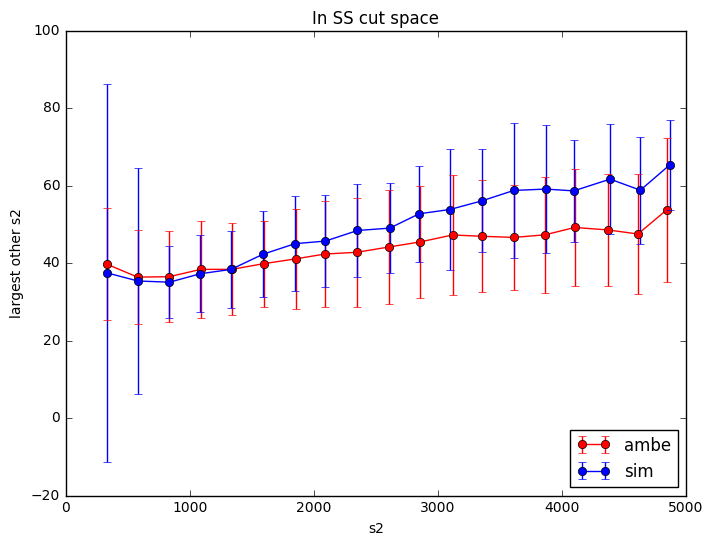

In [37]:
plt.figure(figsize=(8,6))
plt.errorbar(ambe_s2_and_other.s2, ambe_s2_and_other.s2_1_area, ambe_s2_and_other.sigma, label='ambe', color='r', marker = 'o')
plt.errorbar(sim_s2_and_other.s2, sim_s2_and_other.s2_1_area, sim_s2_and_other.sigma, label='sim', color='b', marker = 'o')

plt.xlabel('s2')
plt.ylabel('largest other s2')

plt.title('In SS cut space')

plt.legend(loc='lower right')
plt.show()

# Diffusion

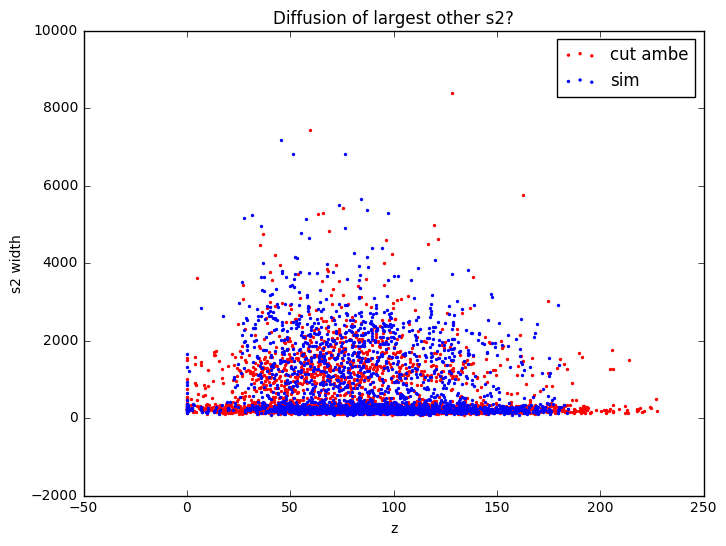

In [38]:
plt.figure(figsize = (8,6))
plt.scatter(-cut_ambe.s2_1_z, cut_ambe.s2_1_range_50p_area,label='cut ambe', color='r',s = 2)
plt.scatter(-sim.s2_1_z, sim.s2_1_range_50p_area,label='sim',color = 'b',s = 2)

plt.title('Diffusion of largest other s2?')
plt.xlabel('z')
plt.ylabel('s2 width')

plt.legend(loc = 'upper right')
plt.show()

Why is simulation displaced down in the detector? z is determined via the drift time and electron lifetime. is it offset?

# Electron Lifetime

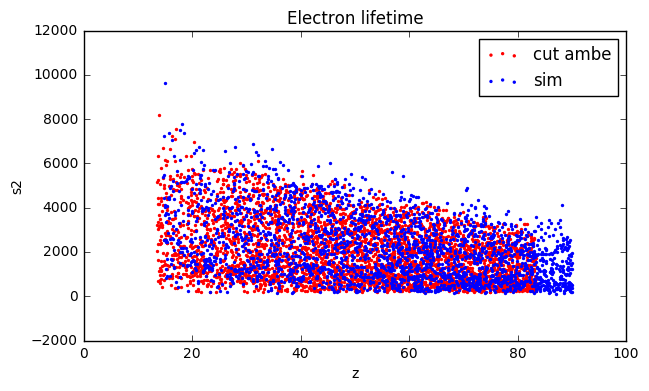

In [39]:
plt.figure(figsize = (7,4))
plt.scatter(-cut_ambe.z, cut_ambe.s2,label='cut ambe', color='r',s = 2)
plt.scatter(-sim.z, sim.s2,label='sim',color = 'b',s = 2)

plt.title('Electron lifetime')
plt.xlabel('z')
plt.ylabel('s2')

plt.legend(loc = 'upper right')
plt.show()

lifetime (us):583.57510921291839
+/-0.00011049880980038902


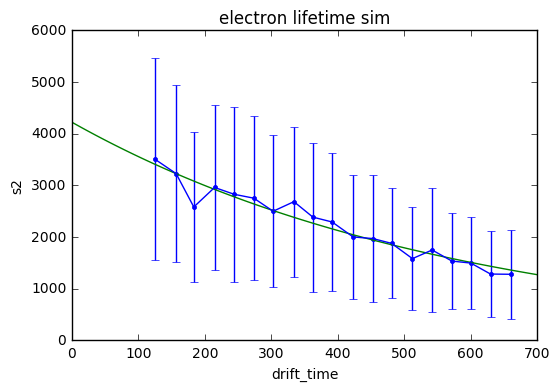

In [40]:
from scipy.optimize import curve_fit

def exp_func(x,a,b):
	return a*np.exp(-b*x)

sim['drift_time'] = sim['z'] / (1.335 * 0.1)
cut_ambe['drift_time'] = cut_ambe['z'] / (1.335 * 0.1)

##############################################
d1 = sim
d1.drift_time = abs(d1.drift_time)
minz = min(d1.drift_time)
maxz = max(d1.drift_time)

bins = np.linspace(minz, maxz, 20)

ds = slicing(d1, 'drift_time', 's2', bins)

popt, pcov = curve_fit(exp_func, ds.drift_time, ds.s2, p0 = (5000,1e-5))

xx = np.linspace(0,700,100)
yy = exp_func(xx, *popt)

plt.plot(ds.drift_time, ds.s2,'.',xx,yy,'-')

plt.errorbar(ds.drift_time, ds.s2, yerr = ds.sigma,color='b')

plt.title('electron lifetime sim')
plt.xlabel('drift_time')
plt.ylabel('s2')

print('lifetime (us):' + repr( 1/popt[1]))
print('+/-' + repr(np.sqrt(pcov[1,1])))

plt.show()

lifetime (us):620.43030106583547
+/-9.5792794095360032e-05


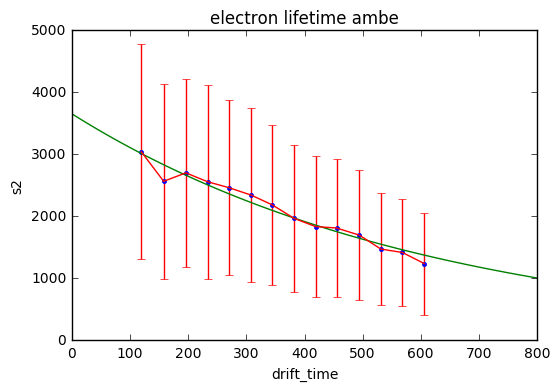

In [41]:
##############################################
d1 = cut_ambe
d1.drift_time = abs(d1.drift_time)
minz = min(d1.drift_time)
maxz = max(d1.drift_time)

bins = np.linspace(minz, maxz, 15)

ds = slicing(d1, 'drift_time', 's2', bins)

popt, pcov = curve_fit(exp_func, ds.drift_time, ds.s2, p0 = (5000,1e-5))

xx = np.linspace(0,800,100)
yy = exp_func(xx, *popt)

plt.plot(ds.drift_time,ds.s2,'.',xx,yy,'-')

plt.errorbar(ds.drift_time, ds.s2, yerr = ds.sigma,color='r')

plt.title('electron lifetime ambe')
plt.xlabel('drift_time')
plt.ylabel('s2')

print('lifetime (us):' + repr( 1/popt[1]))
print('+/-' + repr(np.sqrt(pcov[1,1])))

plt.show()

# Distance between s2, largest other s2

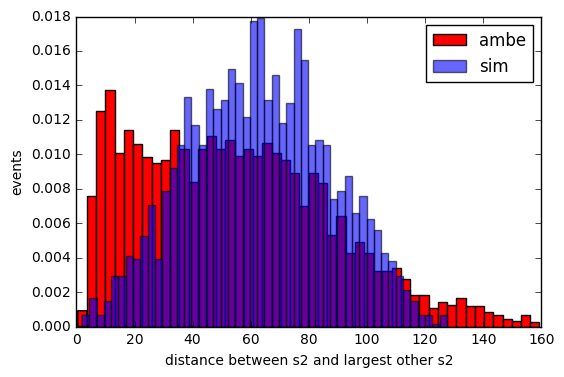

In [42]:
cut_ambe['dist'] = np.sqrt((cut_ambe.s2_1_x - cut_ambe.x)**2 + 
                           (cut_ambe.s2_1_y - cut_ambe.y)**2 + 
                           (cut_ambe.s2_1_z - cut_ambe.z)**2 )

sim['dist'] = np.sqrt((sim.s2_1_x - sim.x)**2 + 
                           (sim.s2_1_y - sim.y)**2 + 
                           (sim.s2_1_z - sim.z)**2 )


plt.hist(cut_ambe.dist.dropna(), bins=50, normed = 1, color='r', label = 'ambe')
plt.hist(sim.dist.dropna(), bins=50, normed = 1, color='b', label='sim', alpha = 0.6)

plt.xlabel('distance between s2 and largest other s2')
plt.ylabel('events')

plt.legend(loc='upper right')

plt.show()

# Area, goodness of fit

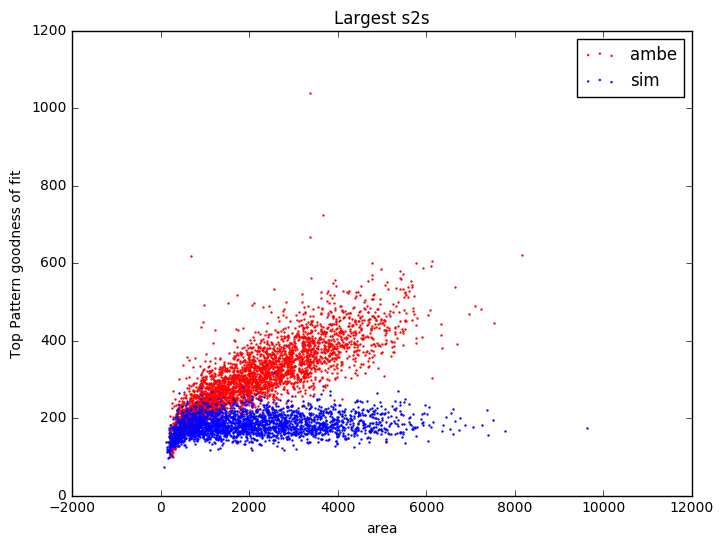

In [51]:
plt.figure(figsize = (8,6))

plt.scatter(cut_ambe.s2, cut_ambe.s2_pattern_fit,label='ambe',color = 'r',s = 0.5)

plt.scatter(sim.s2, sim.goodness_of_fit,label='sim',color = 'b',s = 0.5)
def area_cut(area):
    return 15*(area - 10)**.45

x = np.linspace(0,30000,100)

plt.title('Largest s2s')
plt.xlabel('area')
plt.ylabel('Top Pattern goodness of fit')

# plt.plot(x, area_cut(x),color = 'g')

plt.legend(loc = 'upper right')
plt.show()

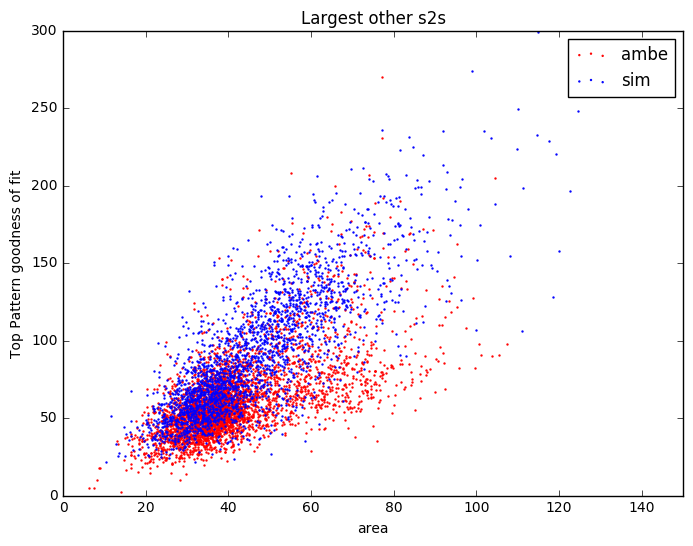

In [44]:
plt.figure(figsize = (8,6))

plt.scatter(cut_ambe.s2_1_area, cut_ambe.s2_1_goodness_of_fit,label='ambe',color = 'r',s = 0.5)

plt.scatter(sim.s2_1_area, sim.s2_1_goodness_of_fit,label='sim',color = 'b',s = 0.5)
def area_cut(area):
    return 15*(area - 10)**.45

x = np.linspace(0,300,100)

plt.xlim(0,150)
plt.ylim(0,300)
plt.title('Largest other s2s')
plt.xlabel('area')
plt.ylabel('Top Pattern goodness of fit')

# plt.plot(x, area_cut(x),color = 'g')

plt.legend(loc = 'upper right')
plt.show()

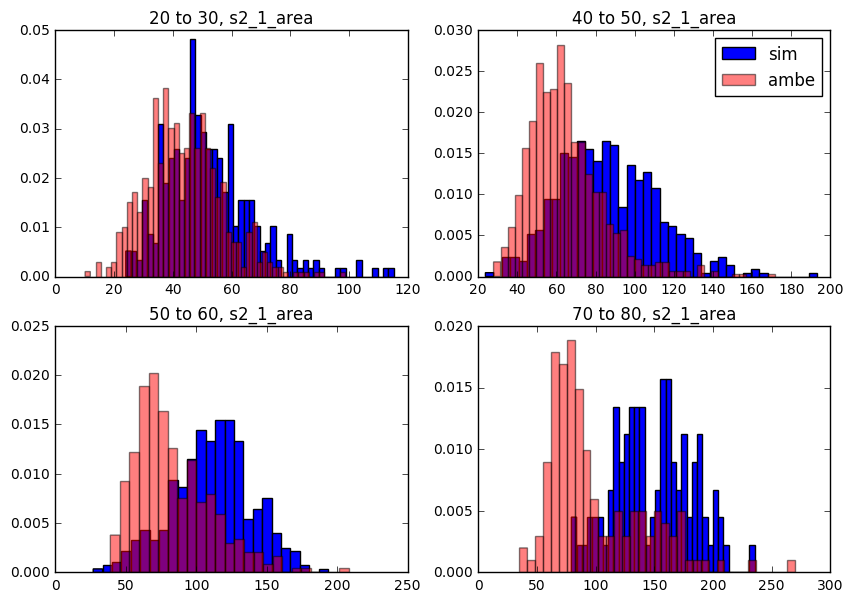

In [45]:
fig = plt.figure(figsize=(10,6))

plot_ranges = [[20,30],[40,50],[50,60],[70,80]]

four_hist_compare(sim, cut_ambe, 's2_1_area', 's2_1_goodness_of_fit', plot_ranges)

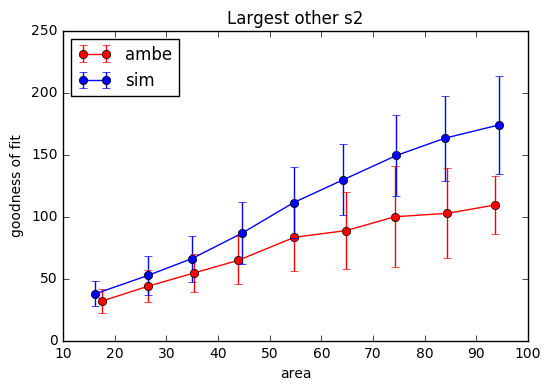

In [46]:
gof_bins = np.linspace(10,100,10)

gof_ambe = slicing(cut_ambe, 's2_1_area', 's2_1_goodness_of_fit', gof_bins)
gof_sim = slicing(sim, 's2_1_area', 's2_1_goodness_of_fit', gof_bins)

plt.errorbar(gof_ambe.s2_1_area, gof_ambe.s2_1_goodness_of_fit, gof_ambe.sigma, label='ambe', color='r', marker = 'o')
plt.errorbar(gof_sim.s2_1_area, gof_sim.s2_1_goodness_of_fit, gof_sim.sigma, label='sim', color='b', marker = 'o')

plt.xlabel('area')
plt.ylabel('goodness of fit')

plt.title('Largest other s2')

plt.legend(loc='upper left')
plt.show()